# Lab 3: CNNs and Deep Learning 
**(version 1.0)**

### TBMI26/732A55 Neural Networks and Learning Systems 2020
### Michael Felsberg
---

---
## 2D Convolution
It is widely used with 2D signals such as images. For the further steps, we often need to visualize an image and we define a shortcut for that:

In [1]:
from matplotlib import pyplot as plt

def visualize(img, title=''):
    plt.imshow(img,'gray')
    plt.colorbar()
    plt.title(title)
    plt.show()
    print('Image size:', img.shape)

---
**Task 1:** Convolution can be performed in 2D using the function `scipy.signal.convolove2d()`. Use this function to generate a 2D kernel of size $33\times33$ by five times cascading 2D convolutions of $H$ with itself, starting with $H = \begin{array}{|c|c|}
      \hline
      1 & 1 \\
      \hline
      1 & 1 \\
      \hline
    \end{array}/4$.   
*Visualize* the kernel using `visualize` function defined above.   

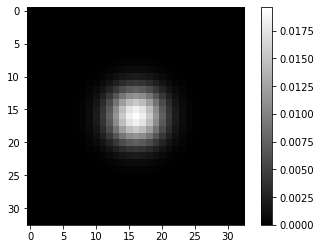

Image size: (33, 33)


In [2]:
# YOUR CODE HERE
from scipy import signal
H = [[1/4,1/4],[1/4,1/4]]
for i in range(5):
    H = signal.convolve2d(H,H)

visualize(H)

In [3]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(H.sum().round()==1)

---
**Task 2:** Now, load the image `'MR15^044.JPG'` (a sample from ImageNet), **sum** its RGB-channels, **normalize** it to the range [0,1], and convolve it with $H$ from task 3 under the options `'valid'` and `'same'`. 

What differences do you observe regarding the size of the output?



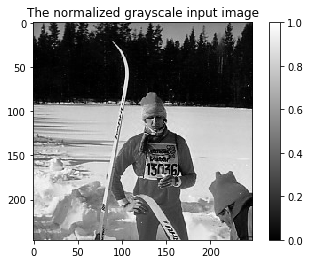

Image size: (246, 248)


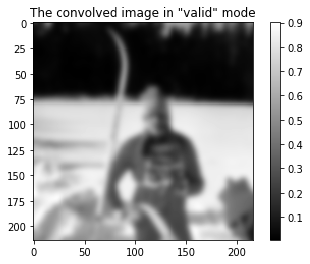

Image size: (214, 216)


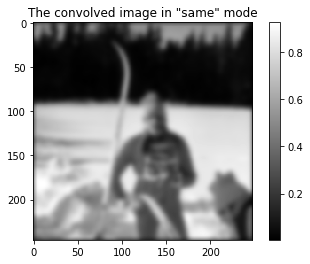

Image size: (246, 248)


In [4]:
# YOUR CODE HERE
import matplotlib.image as mpimg
import numpy as np

our_image = mpimg.imread('MR15^044.JPG')
img_gray = np.dot(our_image[...,:3], [1,1,1])
img_gray = img_gray / img_gray.max()

omg_sc_valid = signal.convolve2d(img_gray,H, 'valid')
omg_sc_same = signal.convolve2d(img_gray,H, 'same')

visualize(img_gray, 'The normalized grayscale input image')      
visualize(omg_sc_valid, 'The convolved image in "valid" mode')
visualize(omg_sc_same, 'The convolved image in "same" mode')

In [5]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(img_gray.max() == 1.0)
assert(omg_sc_valid.shape == (214, 216))
assert(omg_sc_same.shape == (246, 248))

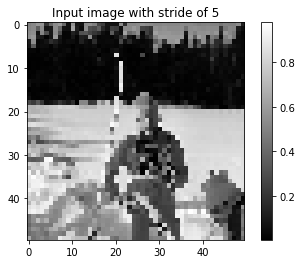

Image size: (50, 50)


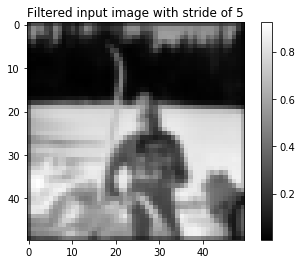

Image size: (50, 50)


In [6]:
# YOUR CODE HERE
img_gray_ds = img_gray[::5,::5]
omg_sc_same_ds = omg_sc_same[::5,::5]
visualize(img_gray_ds, 'Input image with stride of 5')
visualize(omg_sc_same_ds, 'Filtered input image with stride of 5')

What do you observe, in particular at the ski?

YOUR ANSWER HERE
The omg_sc_same_ds image is smoother since it takes into account the neighboring pixel values before it removes them.

low pass fiultering aliasing


## Convolution in PyTorch
PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing. It is primarily developed by Facebook's AI Research lab.

We will start by utilizing PyTorch to perform convolution operations in 2D.

---
**Task 4:** Apply the cascaded $33\times33$ filter from task 1 to the image using a `torch.nn.Conv2d` layer. 

Compare the results from *Scipy* in task 2 and *PyTorch* in this task by subtracting the output images.

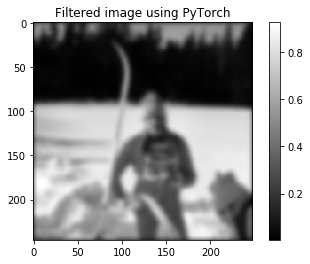

Image size: (246, 248)


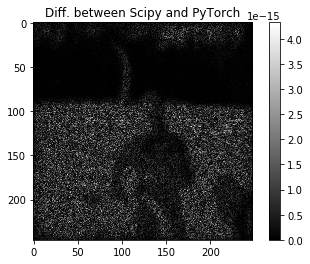

Image size: (246, 248)
4.55746714821857e-16


In [7]:
# YOUR CODE HERE
import torch
#conv2d = torch.nn.Conv2d(1,1,kernel_size = [33,33], padding = 16).double()
img_d = torch.from_numpy(np.asarray(img_gray.reshape(1,1,246,248)))
kernel_weights =  torch.from_numpy(np.asarray(H.reshape(1,1,33,33)))
#torch.FloatTensor()
out_2d_np = torch.conv2d(img_d, kernel_weights, padding=16)[0,0,:,:].detach().numpy()
#out_2d_np = (conv2d(img_d)[0,0,:,:]).detach().numpy()
#torch.from_numpy()

# Hint: Convert the output tensor to numpy array
visualize(out_2d_np, 'Filtered image using PyTorch')
diff = np.abs(out_2d_np-omg_sc_same)
visualize(diff, 'Diff. between Scipy and PyTorch')

print(diff.mean())

In [8]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(diff.mean()<1e-7)

---
**Task 5:** Repeat the previous task with stride 5. Compare with `omg_sc_same_ds` from task 3.

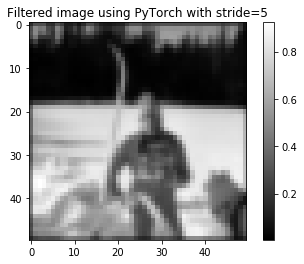

Image size: (50, 50)


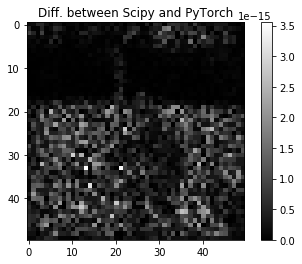

Image size: (50, 50)


In [9]:
# YOUR CODE HERE
out_2d_s5_np = torch.conv2d(img_d, kernel_weights, stride = 5, padding=16)[0,0,:,:].detach().numpy()

# Hint: Convert the output tensor to numpy array
visualize(out_2d_s5_np, 'Filtered image using PyTorch with stride=5') 
diff_s5 = np.abs(out_2d_s5_np-omg_sc_same_ds)
visualize(diff_s5, 'Diff. between Scipy and PyTorch')

In [10]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(diff_s5.mean()<1e-6)

---
**Task 6:** Repeat task 5 with stride of 5 and a $1\times1$ filter. Compare with `img_gray_ds` from task 3.

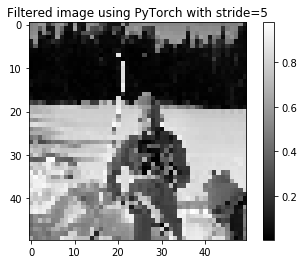

Image size: (50, 50)


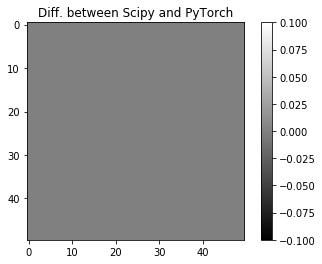

Image size: (50, 50)


In [11]:
# YOUR CODE HERE
one = np.asarray([[1.0]])
kernel_weights =  torch.from_numpy(np.asarray(one.reshape(1,1,1,1)))
out_2d_s5_1_np = torch.conv2d(img_d, kernel_weights, stride = 5, padding=0)[0,0,:,:].detach().numpy()

# Hint: Convert the output tensor to numpy array
visualize(out_2d_s5_1_np, 'Filtered image using PyTorch with stride=5') 
diff_s5_1 = np.abs(out_2d_s5_1_np-img_gray_ds)
visualize(diff_s5_1, 'Diff. between Scipy and PyTorch')

In [12]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(diff_s5_1.mean()<1e-7)

---
## Training a PyTorch Convolution layer

Now, we want the network to learn the convolution filter given the input and the filtered output.

**Task 7:** Considering the input image tensor `inp_2d` from task 4 as a *batch* and the filtered output `out_2d_t` as a label, use `torch.optim.SGD` to learn the the filter $H$.

**Hints**:
- Use the L1 loss from `torch.nn.functional.l1_loss`.
- Use a small learning rate.
- Detach `out_2d_t` from the model graph in task 4 to avoid errors.
- Iterate for 500 iterations.
- Clip the weights after each iteration to $[0, \infty[$ for stable convergence.
- Print the loss every 100 steps.

torch.Size([1, 1, 246, 248])
torch.Size([1, 1, 246, 248])
0.2639615833759308
0.05895506590604782
0.015980614349246025
0.05643434450030327
0.054577652364969254


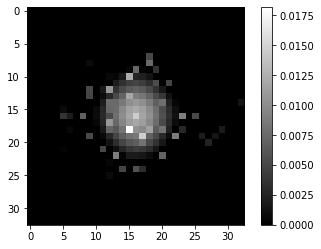

Image size: (33, 33)


In [13]:
# Define the model and the optimizer
# YOUR CODE HERE
model_1layer = torch.nn.Conv2d(1,1,kernel_size = [33,33], padding = 16, bias = False).cuda()
inp_2d   = img_d.float().cuda()
out_2d_t = torch.from_numpy(np.asarray(out_2d_np.reshape(1,1,246,248))).float().cuda()

print(inp_2d.size())
print(out_2d_t.size())

optimizer = torch.optim.SGD(model_1layer.parameters(), lr = 0.001)
loss_fn = torch.nn.functional.l1_loss
for i in range(500):
    y_pred = model_1layer(inp_2d)
    loss = loss_fn(y_pred, out_2d_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    for parameter in model_1layer.parameters():
        parameter.data.clamp_(0)
        
    #for k in range(33):
     #   for j in range(33):
      #      if model_1layer.weight[k,j] < 0:
       #         model_1layer.weight[k,j] = 0
    if i % 100 == 0:
        print(loss.item())
        

    
# Visualize the trained filter
visualize(model_1layer.weight[0,0,:,:].detach().cpu().numpy())

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

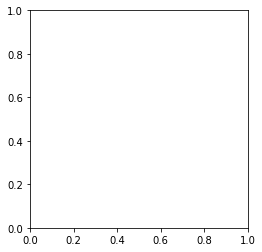

In [14]:
visualize(out_2d_t[0,0,:,:])
visualize(y_pred[0,0,:,:].detach().numpy())

In [15]:
torch.__version__

'1.4.0'

**Task 8**:
To make the transitiong to the next task easier, redo task 7 by defining a custom PyTorch module which includes only 1 convolution layer.  
You can follow this [tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#define-the-network).  
A custom module class inherits `torch.nn.Module` class and needs to have two mandatory functions:
- `__init__(self):` where you define layers included in your module.
- `forward(self, x):` where you define the inference steps of your network.

The built-in auto-differentiation module in PyTorch will keep track of the operations that you perform in the inference steps and calculates their derivatives when you back-propagate the loss function during training.

torch.Size([1, 1, 246, 248])
torch.Size([1, 1, 246, 248])
0.3184787333011627
2.1731207370758057
1.468077301979065
0.8620128631591797
0.3858449161052704
0.10387416183948517
0.07863365858793259
0.07209928333759308
0.06597575545310974
0.06006218120455742
0.054379966109991074
0.04902037978172302
0.043876223266124725
0.039083875715732574
0.034714024513959885
0.030691320076584816
0.026848698034882545
0.02330838143825531
0.020219935104250908
0.017649756744503975
0.015339643694460392
0.01318299025297165
0.011168381199240685
0.0094324741512537
0.007933614775538445
0.00661495653912425
0.005433331243693829
0.004444433376193047
0.0036156007554382086
0.0029435697942972183


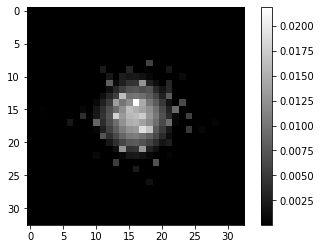

Image size: (33, 33)


In [16]:
# YOUR CODE HERE
class OurModel(torch.nn.Module):
    def __init__(self):
        super(OurModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(1,1,kernel_size = [33,33], padding = 16, bias = False)

    def forward(self, x):
        return self.conv1(x)

net = OurModel().cuda()
inp_2d   = img_d.float().cuda()
out_2d_t = torch.from_numpy(np.asarray(out_2d_np.reshape(1,1,246,248))).float().cuda()

print(inp_2d.size())
print(out_2d_t.size())

optimizer = torch.optim.SGD(net.parameters(), lr = 0.0001)
loss_fn = torch.nn.functional.l1_loss
for i in range(3000):
    y_pred = net(inp_2d)
    loss = loss_fn(y_pred, out_2d_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    net.conv1.weight.data.clamp_(0)
    if i % 100 == 0:
        print(loss.item())
        

# Visualize the trained filter
visualize(net.conv1.weight[0,0,:,:].detach().cpu().numpy())
        

---
## Training a whole network
So far, we have experimented with training a single convolution layer. Now we try to train a whole network to perform the task of image classification on CIFAR-10 dataset.  
But first, make sure that CUDA is available by running the following command:

In [17]:
import torch
print("CUDA Available: ",torch.cuda.is_available())



CUDA Available:  True


**Task 9:** We will train on CIFAR10, which is readily available at `torchvision.datasets.CIFAR10`. 

Create a dataloader for the *training* and the *test* sets of CIFAR10 using `torch.utils.data.DataLoader` , then show some examples from the training set using `torchvision.utils.make_grid` and print out their labels. 

*Hints* :
- The `imshow` function for visualizing the images is provided below.
- Use `torchvision.transforms` to perform whitening on images (normalization using the mean and the standard deviation).
- Use a batch size of 64.

Files already downloaded and verified
Files already downloaded and verified


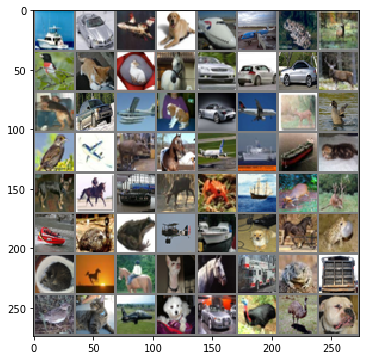

 ship   car plane   dog plane plane  frog  deer  bird   cat   cat horse   car   car   car  deer   dog   car plane   dog   car plane  deer  bird  bird plane  deer horse plane  ship  ship   cat   dog horse   car  deer  frog  ship  deer  deer  ship  bird  frog plane  ship   dog horse  frog   cat horse horse   dog horse truck  frog truck  bird   cat plane   dog   car  bird  bird   dog


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision as torchvision


def imshow(img):
    img = img * 0.2 + 0.5  # Un-Normalize, Change according to your normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return npimg.mean()

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# YOUR CODE HERE
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Show some random images
dataiter = iter(trainloader)
images, labels = dataiter.next()
grid_img = torchvision.utils.make_grid(images)
imshow(grid_img)

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [19]:
### TEST CELL. PLEASE DON'T CHANGE ###
assert(grid_img.std()>0.8)

---
## Baseline Model
**Task 10:** Build the depicted LeNet5-inspired model using PyTorch standard components. Assume a **padding** with `same` mode for all convolution layers.   
Try to figure out the missing dimension at the first fully connected layer.
![architecture](arch.png)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the network
        # YOUR CODE HERE
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels = 32, kernel_size = [3,3], padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = [3,3], padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[2,2], stride=2, padding = 1),
            nn.Conv2d(in_channels = 64, out_channels = 128,kernel_size = [3,3], padding = 1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128,kernel_size = [3,3], padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[2,2], stride=2, padding = 1),
            nn.Dropout2d(p=0.05),
            nn.Conv2d(in_channels = 128, out_channels = 256,kernel_size = [3,3], padding = 1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256,kernel_size = [3,3], padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=[2,2], stride=2, padding = 1),
            nn.Dropout(p=0.1)
        )
                                
                                           
        self.conv2 = nn.Sequential(            
            nn.Linear(in_features=6400, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=512, out_features=10)
        )
        
        
    def forward(self, x):
        # Perform Inference            
        # YOUR CODE HERE
        x = self.conv1(x)
        x = x.flatten(1,3)
        return self.conv2(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = LeNet5().cuda()

---
**Task 11:** Train the LeNet5 model for 40 epochs using a suitable batch size and display the result.

*Hints*:
- Define an optimizer, e.g. SGD optimizer.
- Define a suitable loss function.
- Iterate for 40 epochs and at each epoch calculate a running loss and accuracy on the training set.
- After each epoch, evaluate the model on the test set. You can achieve this by **completing** the `test` function below that performs *only* inference on the test set and calculates the accuracy.

In [21]:
# A function to plot the accuracy training history
def plot_model_history(history):
    plt.figure(0)
    plt.plot(history['train'],'r', lw=3)
    plt.plot(history['test'],'b', lw=3)
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy vs Test Accuracy")
    plt.legend(['Training','Test'])
    plt.grid(True)

    
    
# Test function that runs only inference
def test(model, testloader):
    correct = 0
    total = 0 
    for data in testloader:
        inputs, labels = data
        output = model(inputs.cuda())
        _, predicted = torch.max(output.data,1)
        predicted.cpu()
        for i in range(len(predicted)):
            if labels[i] == predicted[i]:
                correct += 1
            total += 1
        
    print('Test Accuracy: %d %%' % (100 * correct / total))
    return correct / total

test
Test Accuracy: 46 %
Train Accuracy: 36 %


test
Test Accuracy: 59 %
Train Accuracy: 55 %


test
Test Accuracy: 63 %
Train Accuracy: 65 %


test
Test Accuracy: 69 %
Train Accuracy: 71 %


test
Test Accuracy: 68 %
Train Accuracy: 75 %


test
Test Accuracy: 71 %
Train Accuracy: 78 %


test
Test Accuracy: 76 %
Train Accuracy: 81 %


test
Test Accuracy: 76 %
Train Accuracy: 83 %


test
Test Accuracy: 78 %
Train Accuracy: 85 %


test
Test Accuracy: 79 %
Train Accuracy: 86 %


test
Test Accuracy: 77 %
Train Accuracy: 88 %


test
Test Accuracy: 76 %
Train Accuracy: 90 %


test
Test Accuracy: 73 %
Train Accuracy: 91 %


test
Test Accuracy: 80 %
Train Accuracy: 92 %


test
Test Accuracy: 79 %
Train Accuracy: 93 %


test
Test Accuracy: 81 %
Train Accuracy: 95 %


test
Test Accuracy: 81 %
Train Accuracy: 96 %


test
Test Accuracy: 75 %
Train Accuracy: 96 %


test
Test Accuracy: 79 %
Train Accuracy: 97 %


test
Test Accuracy: 75 %
Train Accuracy: 97 %


test
Test Accuracy: 80 %
Train Accuracy:

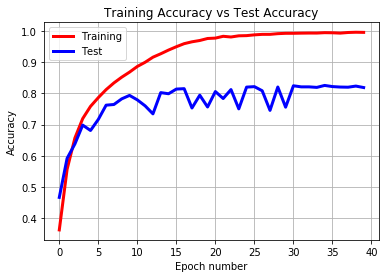

In [22]:
NUM_EPOCHS = 40
LR = 0.01

# Define a proper optimizer and a proper loss function

optimizer = torch.optim.SGD(net.parameters(), lr = LR)
loss_fn = torch.nn.CrossEntropyLoss()


acc_history = {'train':[], 'test':[]}

# Iterate for N epochs



for epoch in range(NUM_EPOCHS):
    total = 0
    correct = 0
    for data in trainloader:
        inputs, labels = data
        
        optimizer.zero_grad()
        outputs = net(inputs.cuda())
        loss = loss_fn(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data,1)
        #labels.cpu()
        #predicted.cpu()
        for i in range(len(labels)):
            if predicted[i] == labels[i]:
                correct += 1
            total += 1
    print("test")
    acc_history['train'].append(correct/total)
    test_acc = test(net,testloader)
    acc_history['test'].append(test_acc)
    print('Train Accuracy: %d %%' % (100 * correct / total))
    #print("test acc: %0.2f" % test_acc)
    print("\n")

print('Finished Training!')

plot_model_history(acc_history)

# Let's quickly save our trained model:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## == MANDATORY QUESTIONS END HERE ==

---

### Baseline + Decaying Learning Rate
In most papers, the learning rate is successively reduced in order to boost the final performance, e.g. divided by two after 20 and 30 epochs.  
**[EXTRA]**
**Task 12:** Define a suitable function and train the previous model with decaying learning rate. Plot the result and compare it to the baseline.

In [4]:
def adjust_learning_rate(optimizer, epoch):    
    for param_group in optimizer.param_groups:
        lrate = param_group["lr"]
        # YOUR CODE HERE
        raise NotImplementedError()

In [5]:
net_lr = LeNet5().to(device)

# Define a proper optimizer and a proper loss function
# YOUR CODE HERE
raise NotImplementedError()

acc_history_lr = {'train':[], 'test':[]}
# Iterate for N epochs
# YOUR CODE HERE
raise NotImplementedError()
print('Finished Training!')

plot_model_history(acc_history_lr)

# Let's quickly save our trained model:
PATH = './cifar_net_lr.pth'
torch.save(net_lr.state_dict(), PATH)

NotImplementedError: 

---
### Baseline +  Decaying Learning rate + Data Augmentation 
**[EXTRA]**
**Task 13:** Data augmentation is known to reduce overfitting. Use `torchvision.transforms`to perform additional augmentation with flipping and random cropping. Adjust the number of epochs and the learning rate schedule if needed. What do you observe?

In [6]:
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [7]:

net_lr_wr_aug = LeNet5().to(device)

# Define a proper optimizer and a proper loss function
# YOUR CODE HERE
raise NotImplementedError()

acc_history_lr_wr_aug = {'train':[], 'test':[]}
# Iterate for N epochs
# YOUR CODE HERE
raise NotImplementedError()
print('Finished Training!')

plot_model_history(acc_history_lr_wr_aug)

# Let's quickly save our trained model:
PATH = './cifar_net_lr_wr_aug.pth'
torch.save(net_lr_wr_aug.state_dict(), PATH)

NotImplementedError: 